In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psycopg2

import re
from tqdm import tqdm

In [21]:
# Connection details
dbname = 'defaultdb'
user = 'doadmin'
password = 'AVNS_pWw7oK1YPADBn-TRPqp'
host = 'db-postgresql-fra1-12797-do-user-8775628-0.c.db.ondigitalocean.com'
port = '25060'

conn = psycopg2.connect(f"dbname={dbname} user={user} password={password} host={host} port={port}")
df = pd.read_sql_query('SELECT * FROM raw_data', conn)
df = df.drop('id', axis=1)
conn.close()

C:\Users\Sergey\AppData\Local\Temp\ipykernel_2308\1137522600.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('SELECT * FROM raw_data', conn)


## Main

In [22]:
df.describe(include='all')

,website,section,url,header,body,date,tags
count,39776,39776,39776,39776,39776,39776,39776
unique,4,201,39766,39172,39756,38616,27763
top,Интерфакс,Новости компаний и новости по акциям,https://ria.ru/20230531/peregovory-1875357995....,"""Газпром"" подает газ через Украину на ГИС ""Суд...",Источник,"02.08.2023, 01:21",[]
freq,14686,12472,2,34,3,5,2671


> __Выводы:__  
> 1. Можно заметить, что у нас нет пропусков в данных  
> 2. Можно заметить, что у нас есть url'ы, которые представлены более одного раза, что намекает нам на наличие дубликатов, от которых ужно будет избавиться  
> 3. Можно заметить, что у нас есть новости с похожими заголовками, как следствие, нужно будет понять, являются ли такие новости дубликатами и определиться, что с ними делать  
> 4. Можно заметить, что у нас есть новости с полностью повторяющимися текстами небольшой длины, что, скорее всего, свидетельствует о необходимости избавиться от подобных 'пустых' новостей 

## URL

In [46]:
df[['url']].groupby('url').value_counts().sort_values().tail(11)

url
https://smart-lab.ru/blog/896323.php                  1
https://ria.ru/20230531/mongoliya-1875328673.html     2
https://ria.ru/20230531/gaz-1875325632.html           2
https://ria.ru/20230531/vstrecha-1875349749.html      2
https://ria.ru/20230531/volkswagen-1875349174.html    2
https://ria.ru/20230531/gaz-1875314656.html           2
https://ria.ru/20230531/gaz-1875308876.html           2
https://ria.ru/20230531/peregovory-1875357995.html    2
https://ria.ru/20230531/rosneft-1875372066.html       2
https://ria.ru/20230531/gazprom-1875372984.html       2
https://ria.ru/20230531/nalog-1875319473.html         2
dtype: int64

In [47]:
'''
Не указываем, по какой колонке убирать дубликаты, чтобы убедиться, 
что эти 10 новостей точные дубликаты уже представленных новостей
'''
df_new = df.drop_duplicates()

In [48]:
df_new.describe(include='all')

,website,section,url,header,body,date,tags
count,39766,39766,39766,39766,39766,39766,39766
unique,4,201,39766,39172,39756,38616,27763
top,Интерфакс,Новости компаний и новости по акциям,https://www.interfax.ru/russia/879448,"""Газпром"" подает газ через Украину на ГИС ""Суд...",Источник,"17.08.2023, 00:50",[]
freq,14686,12472,1,34,3,5,2671


> __Выводы:__ Теперь все url'ы у нас уникальны (к тому же, мы поняли, что эти 10 удаленных новостей были полными дубликатами уже представленных новостей)

## Body

#### 1. Почистим тексты от неинформативных частей

1.1 В первую очередь, избавимся от внешних ссылок в текстах (в тестовом формате)

In [49]:
patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
]

In [50]:
links = []
ids = []

for i in tqdm(range(df_new.shape[0])):
    for pattern in patterns:
        lst_help = re.findall(pattern, df_new.iloc[i,:].body)
        if lst_help:
            links.extend(lst_help)
            ids.append(i)

print(len(links))
print(links)

100%|███████████████████████████████████████████████████████████████████████████| 39766/39766 [00:40<00:00, 989.83it/s]

8198
['https://www.interfax.ru/business/886147', 'www.reuters.com/business/energy/saudi-arabia-imports-record-russian-fuel-oil-june-trade-grows-2023-07-13/', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1781652', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1781649', 'fomag.ru/news-streem/primenenie-byudzhetnykh-pravil-ne-garantiruet-stranam-stabilizatsiyu-raskhodov-rbk/', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1782187', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1792363', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1782879', 'https://www.e-disclosure.ru/portal/fileload.ashx?fileid=1781709', 'www.bloomberg.com/news/live-blog/2023-03-15/credit-suisse-in-crisis?srnd=premium-europe', 'www.bloomberg.com/news/articles/2023-06-02/what-asia-investors-worry-most-about-from-china-bonds-to-pakistan-debt', '\n1prime.ru/banks/20230309/840015283.html', 'https://m.gazeta.ru/business/news/2023/03/11/19941595.shtml', 'https://www.ved

Теперь же, после того, как мы убедились, что наш regex pattern правильно отыскивает внешние ссылки в текстах (по крайней мере, значительную их часть), можно от них избавиться в самих текстах

In [51]:
def remove_links(text):
    patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
    ]
    
    for pattern in patterns:
        text = re.sub(pattern, ' ', text)
    
    return text

vectorized_remove_links = np.vectorize(remove_links)

In [52]:
df_new = df_new.copy()
df_new['body'] = vectorized_remove_links(df_new.body)

1.2 Теперь пройдемся по отдельным порталам, в которых повторяются одни и те же куски текста, и избавимся от них (в нашем случае это РИА и Интерфакс)

In [53]:
def sub_ria(text):
    pattern = r'^.*(?:—|-|–) РИА Новости(?:.|,)'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_ria = np.vectorize(sub_ria)

df_new['body'] = vectorized_sub_ria(df_new.body)

In [54]:
def sub_interfax(text):
    pattern = r'^.*INTERFAX.RU'
    return re.sub(pattern, ' ', text, count=1)

vectorized_sub_interfax = np.vectorize(sub_interfax)

df_new['body'] = vectorized_sub_interfax(df_new.body)

#### 2. После того, как мы избавились от неинформативных частей в текстах новостей, можно посмотреть на распределение длин текстов и, как следствие, избавиться от новостей с очень короткими (почти не содержащими информации) текстами и от новостей с полностью дублирующимися текстами

2.1 Сначала удалим короткие новости среди всех порталов

In [55]:
df_new.loc[:, 'body_length'] = df_new['body'].apply(len)

In [56]:
quantile_lst = []
for i in [round(0.01 + 1/100*i, 2) for i in range(10)]:
    length = df_new[["body_length"]].quantile(i)[0]
    quantile_lst.append(length)
    print(f'Квантиль {i}: {int(length)}')
    
quantile_lst = [int(i) for i in quantile_lst]

Квантиль 0.01: 60
Квантиль 0.02: 98
Квантиль 0.03: 123
Квантиль 0.04: 157
Квантиль 0.05: 200
Квантиль 0.06: 241
Квантиль 0.07: 276
Квантиль 0.08: 309
Квантиль 0.09: 337
Квантиль 0.1: 362


In [57]:
for i, quantile_len in enumerate(quantile_lst):
    print(f'Квантиль {(i+1)/100} c длиной: {quantile_len}')
    print(df_new[df_new['body_length']>quantile_len].sort_values(by='body_length').iloc[0,:].body)
    print('-------------------------------------------------------------------------------------')

Квантиль 0.01 c длиной: 60
«Дагестанская энергосбытовая компания» Отчет РСБУ

Источник: 
-------------------------------------------------------------------------------------
Квантиль 0.02 c длиной: 98
07.04.2023 - ТНС энерго Кубань - СД решит по дивидендам

Самые быстрые новости у нас!  

Источник: 
-------------------------------------------------------------------------------------
Квантиль 0.03 c длиной: 123
  Президент России Владимир Путин считает, что важно не допустить ни ускорения, ни избыточного замедления инфляции в стране.
-------------------------------------------------------------------------------------
Квантиль 0.04 c длиной: 157
📉Полиметалл -6% Акции уверенно снижаются, компания попала в SDN лист.  Падение сильнее чем у Полюс Золота, так как теперь переезд в Казахстан под угрозой. 

 
-------------------------------------------------------------------------------------
Квантиль 0.05 c длиной: 200
Процедуру банкротства оператора газопровода Nord Stream 2 AG продлили ещ

Можно заметить, что начиная с квантили 0.05, новости идут уже достаточно информативными, следовательно, все новости с текстами длины менее 200 мы удалим

In [58]:
df_new.drop(df_new[df_new['body_length'] < 200].index, inplace=True)

In [59]:
df_new[['body']].describe()

,body
count,37785
unique,37781
top,Проект увеличения мощности золотоизвлекательно...
freq,2


2.2 Видим, что у нас все еще остались новости с дублирующимися текстами, необходимо избавиться от дубликатов

In [62]:
df_new[['body']].groupby('body').value_counts().sort_values().tail(5)

body
  - Суды приостановили эксплуатацию трех объектов АО "Саханефтегазсбыт" (СНГС) по требованию Ленского управления Ростехнадзора, говорится на сайте надзорного ведомства.\n"Якутский городской суд и Ленский районный суд приостановили деятельность на три месяца на нефтебазах в поселке Усть-Куйга и Олекминск. Эксплуатация нефтебазы в Ленске приостановлена на 30 суток", - говорится в сообщении.\nПо информации управления Ростехнадзора, при проверке объектов компании было выявлено 115 нарушений правил безопасной эксплуатации, в связи с чем наложены временные запреты деятельности на четыре нефтебазы СНГС, однако временный запрет деятельности нефтебазы Якутска горсуд заменил на штраф в размере 200 тыс. рублей.\nВ ходе проверки было установлено, в частности, что объекты не оснащены автоматизированными системами управления, не предусмотрена система противоаварийной автоматической защиты, главный инженер и инженерно-технический персонал не аттестованы в области промышленной безопасности. Кроме

In [63]:
lst_suplicated_body = [i for i in df_new[['body']].groupby('body').value_counts().sort_values().tail(4).keys()]

In [64]:
df_new[df_new['body'].isin(lst_suplicated_body)]

,website,section,url,header,body,date,tags,body_length
2332,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/886788,"Путин разрешил ""Компании ВК"" приобрести 100% д...",- Президент РФ Владимир Путин разрешил приоб...,"22:38, 17 февраля 2023","[""Компания ВК"", ""Деньги.Мэйл.Ру""]",1348
2446,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/886978,Путин разрешил российскому юрлицу VK выкупить ...,- Президент РФ Владимир Путин разрешил приоб...,"13:26, 20 февраля 2023","[""VK"", ""Деньги.Мэйл.ру"", ""Владимир Путин""]",1348
27016,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/950006.php,Селигдар намерен нарастить мощность фабрики на...,Проект увеличения мощности золотоизвлекательно...,"13 октября 2023, 12:28","[""Селигдар"", ""полюс золото""]",1227
27034,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/949931.php,Фабрика «Селигдара» на производственном компле...,Проект увеличения мощности золотоизвлекательно...,"13 октября 2023, 10:25","[""Селигдар"", ""фабрика Рябиновая"", ""золотодобыч...",1227
30223,РИА,Экономика,https://ria.ru/20230404/avto-1862861778.html,Путин пообещал кратное увеличение выпуска авто...,"Президент России Владимир Путин заявил, что ...",12:12 04.04.2023\n(обновлено: 12:29 04.04.2023),"[""Россия"", ""Экономика"", ""Авто"", ""Владимир Путин""]",418
30224,РИА,Экономика,https://ria.ru/20230404/avtoprom-1862860685.html,Путин рассказал о мерах поддержки автопрома,"Президент России Владимир Путин заявил, что ...",12:09 04.04.2023\n(обновлено: 12:36 04.04.2023),"[""Владимир Путин"", ""Экономика"", ""Авто"", ""Россия""]",418
34849,РИА,Ситуация с курсами валют и ценами на нефть,https://ria.ru/20230814/rubl-1890027603.html,"Рубль перешел к росту против доллара, евро и юаня",Рубль перешел к укреплению на сообщении о вн...,17:38 14.08.2023\n(обновлено: 17:42 14.08.2023),"[""Ситуация с курсами валют и ценами на нефть"",...",638
34850,РИА,Ситуация с курсами валют и ценами на нефть,https://ria.ru/20230814/kurs-1890022534.html,Доллар на Мосбирже упал ниже 99 рублей,Рубль перешел к укреплению на сообщении о вн...,17:17 14.08.2023\n(обновлено: 17:42 14.08.2023),"[""Ситуация с курсами валют и ценами на нефть"",...",638


Оставим более ранние новости (больше подходит под наши дальнейшие задачи)

In [65]:
df_new.drop(df_new[df_new.index.isin([2446, 27016, 30223, 34849])].index, inplace=True)

In [66]:
df_new[['body']].describe()

,body
count,37781
unique,37781
top,- Банк России с начала 2023 года отменяет ча...
freq,1


#### 3. После проведенной чистки можно еще взглянуть на распределение длин текстов относительно разных порталов

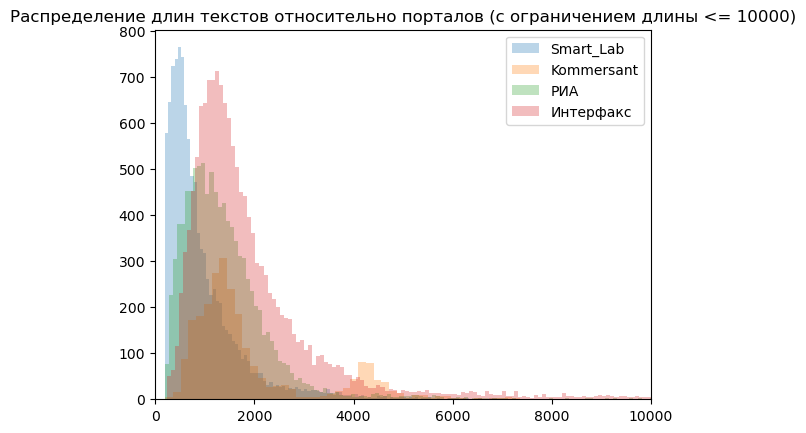

In [67]:
for portal in ['Smart_Lab', 'Kommersant', 'РИА', 'Интерфакс']:
    plt.hist(df_new[df_new['website']==portal].body_length, bins=400, alpha=0.3, label=portal)

plt.xlim(0, 10000)

plt.title('Распределение длин текстов относительно порталов (с ограничением длины <= 10000)')
plt.legend()
plt.show()

> __Выводы:__  
> 1. Мы почистили тексты от неинформативных частей, которые могли бы навредить качеству наших последующих моделей
> 2. После чистики текстов новостей мы избавились от практически неинформативных и дублирующихся новостей 
> 3. Можно заметить, что у нас распределение длин текстов новостей определеятся порталом, из которго новость была взята, на данный момент это не дает нам какой-то конкретной информации (кроме того, что у нас достаточно разношерстный корпусов текстов), но мы будем держать это в уме при последующем обучении моделей 

# Section

> __Рассуждения:__ <рассуждения>

## Header

In [68]:
df_new[df_new['header']=='нЦена бензина Аи-95 на российской бирже обновила рекорд']

,website,section,url,header,body,date,tags,body_length


In [75]:
df_new[['header']].groupby('header').value_counts().sort_values().tail(354)

header
Для дальнейшего значимого восстановления акций Сбера нужно снижение геополитических рисков - Финам     1
Нефть Brent подешевела до $75,5 за баррель                                                             2
VK приобретает 51% в коммуникационном агентстве Didenok Team                                           2
В Кремле рассказали о ситуации с зерновой сделкой                                                      2
Инфляция во Франции в июне замедлилась до 5,3%                                                         2
                                                                                                      ..
ТОП российских акций средней и малой капитализации: обновление состава - СберИнвестиции                6
Рубль утром стабилен относительно доллара и юаня                                                       6
Цена бензина Аи-95 на российской бирже обновила рекорд                                                 9
В России замедлилась недельная инфляция         

> __Выводы:__ <выводы>